# 🔍 Model Inferencing for Ensembles

## ⚙️ Setup 

### 📚 Importing Libraries

Importing from packages

In [1]:
import os
import pandas as pd
import torch
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm

/media/ishfar/New Volume/Studies/Projects/Kaggle-Automated-Essay-Scoring/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir("../../")

Importing user defined packages

In [3]:
from lib.config import config
from lib.paths import Paths
from lib.utils.utils import seed_everything, get_model_path
from lib.data import clean_text, sliding_window
from lib.model.inference import ensemble_inference

In [4]:
seed_everything()

## 📖 Definitions

### 🌎 Global Variables

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
config.model.replace("/", "_")

'microsoft_deberta-v3-xsmall'

In [7]:
model_paths = {get_model_path(i): 1 / config.n_folds for i in range(config.n_folds)}
model_paths

{'output/microsoft/deberta-v3-xsmall/microsoft_deberta-v3-xsmall_fold_0_best.pth': 0.14285714285714285,
 'output/microsoft/deberta-v3-xsmall/microsoft_deberta-v3-xsmall_fold_1_best.pth': 0.14285714285714285,
 'output/microsoft/deberta-v3-xsmall/microsoft_deberta-v3-xsmall_fold_2_best.pth': 0.14285714285714285,
 'output/microsoft/deberta-v3-xsmall/microsoft_deberta-v3-xsmall_fold_3_best.pth': 0.14285714285714285,
 'output/microsoft/deberta-v3-xsmall/microsoft_deberta-v3-xsmall_fold_4_best.pth': 0.14285714285714285,
 'output/microsoft/deberta-v3-xsmall/microsoft_deberta-v3-xsmall_fold_5_best.pth': 0.14285714285714285,
 'output/microsoft/deberta-v3-xsmall/microsoft_deberta-v3-xsmall_fold_6_best.pth': 0.14285714285714285}

## 💿 Loading from Disk

### 🪙 Tokenizer

In [8]:
tokenizer = AutoTokenizer.from_pretrained(Paths.TOKENIZER_PATH)
vocabulary = tokenizer.get_vocab()
total_tokens = len(vocabulary)
print("Total number of tokens in the tokenizer:", total_tokens)
print(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Total number of tokens in the tokenizer: 128003
DebertaV2TokenizerFast(name_or_path='output/microsoft/deberta-v3-xsmall/tokenizer_v2', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	128000: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized

### 🗃️ Dataset

In [9]:
test_df = pd.read_csv(Paths.TRAIN_CSV_PATH)
test_df.shape

(3, 4)

## ⌛ Data Processing

### Cleaning text

In [10]:
test_df["full_text"] = test_df["full_text"].map(lambda x: clean_text(x))

### Sliding Window

In [11]:
test_df = sliding_window(test_df, tokenizer)
test_df.shape

100%|██████████| 3/3 [00:00<00:00, 193.51it/s]


(5, 4)

100%|██████████| 5/5 [00:00<00:00, 1156.28it/s]


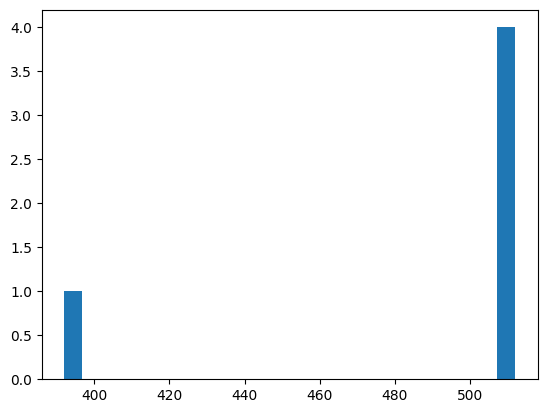

In [12]:
lengths = []
tqdm_loader = tqdm(test_df["full_text"].fillna("").values, total=len(test_df))
for text in tqdm_loader:
    length = len(tokenizer(text, add_special_tokens=False)["input_ids"])
    lengths.append(length)

# config.MAX_LEN = max(lengths) + 3 # cls & sep & sep
_ = plt.hist(lengths, bins=25)

## 🏁 Start Inferencing

In [13]:
predictions = ensemble_inference(test_df.iloc[:101], tokenizer, model_paths, device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 0 Inference: 100%|██████████| 1/1 [00:00<00:00,  1.35test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 1 Inference: 100%|██████████| 1/1 [00:00<00:00, 29.85test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 2 Inference: 100%|██████████| 1/1 [00:00<00:00, 30.85test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 3 Inference: 100%|██████████| 1/1 [00:00<00:00, 29.81test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 4 Inference: 100%|██████████| 1/1 [00:00<00:00, 29.75test_batch/s]
Special tokens have been added in the vocabul

## 💾 Saving submissions

In [14]:
submission = pd.DataFrame()
submission["essay_id"] = predictions["essay_ids"]
submission["score"] = predictions["score"]
submission["score"] = submission["score"] + 1 
print(f"Submission shape: {submission.shape}")
submission.to_csv("data/submission.csv", index=False)
submission

Submission shape: (3, 2)


,essay_id,score
0,000d118,3
1,000fe60,3
2,001ab80,4
